# INM702: Task 2

This task is about forecasting daily mean temperatures using data from a weather station near Heathrow Airport in London, UK. The dataset can be found on Kaggle [here](https://www.kaggle.com/datasets/emmanuelfwerr/london-weather-data).

We use a recurrent neural network to achieve this, though other techniques include standard statistical methods such as the autoregressive integrated moving average (ARIMA). The implementation is done using PyTorch.

The work presented here is part of the coursework of the INM702 module at City, University of London. The Github repository can be found [here](https://github.com/yasirbarlas/City-INM702).

### Import Libraries

In [19]:
# Import libraries
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import torch

# Import libraries for transforming the data
from sklearn.preprocessing import StandardScaler

# Ignore warnings (making the work easier to read)
import warnings
warnings.filterwarnings("ignore")

### Set Random Seeds

In [20]:
randomer = 50
random.seed(randomer)
np.random.seed(randomer)
torch.manual_seed(randomer)

### Import Dataset

In [21]:
df = pd.read_csv("dataset\london_weather.csv", delimiter = ",")

# Check for duplicate rows or NA values
print(df.isnull().sum(), "\n")
print("How Many Duplicate Rows?", df.duplicated().sum())

date                   0
cloud_cover           19
sunshine               0
global_radiation      19
max_temp               6
mean_temp             36
min_temp               2
precipitation          6
pressure               4
snow_depth          1441
dtype: int64 

How Many Duplicate Rows? 0


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15341 entries, 0 to 15340
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              15341 non-null  int64  
 1   cloud_cover       15322 non-null  float64
 2   sunshine          15341 non-null  float64
 3   global_radiation  15322 non-null  float64
 4   max_temp          15335 non-null  float64
 5   mean_temp         15305 non-null  float64
 6   min_temp          15339 non-null  float64
 7   precipitation     15335 non-null  float64
 8   pressure          15337 non-null  float64
 9   snow_depth        13900 non-null  float64
dtypes: float64(9), int64(1)
memory usage: 1.2 MB


### Data Cleaning

We find that there are NA values for the 'mean_temp' column, which is the one that we will be working with. We decide to fill these NA values with an average of the previous 2 days and of the 2 days after. So the NA mean temperature $c$ is calculated as:

$$c = \frac{a + b + d + e}{4}$$

where $a, b, d, e$ are the 2 days before and after the NA value $c$.

In [24]:
# Calculate the average of the three values above and below the NaN value (convenient method to replace the NaN values)
df["mean_temp_filled"] = df["mean_temp"].fillna(
    (df["mean_temp"].shift(1) + df["mean_temp"].shift(2)
     + df["mean_temp"].shift(-1) + df["mean_temp"].shift(-2)) / 4
)

# Drop old 'mean_temp' column, replace with the new one that filled the NaN values
df.drop(["mean_temp"], axis = 1, inplace = True)
df.rename(columns = {"mean_temp_filled": "mean_temp"}, inplace=True)

df

,date,cloud_cover,sunshine,global_radiation,max_temp,min_temp,precipitation,pressure,snow_depth,mean_temp
0,19790101,2.0,7.0,52.0,2.3,-7.5,0.4,101900.0,9.0,-4.1
1,19790102,6.0,1.7,27.0,1.6,-7.5,0.0,102530.0,8.0,-2.6
2,19790103,5.0,0.0,13.0,1.3,-7.2,0.0,102050.0,4.0,-2.8
3,19790104,8.0,0.0,13.0,-0.3,-6.5,0.0,100840.0,2.0,-2.6
4,19790105,6.0,2.0,29.0,5.6,-1.4,0.0,102250.0,1.0,-0.8
...,...,...,...,...,...,...,...,...,...,...
15336,20201227,1.0,0.9,32.0,7.5,7.6,2.0,98000.0,NaN,7.5
15337,20201228,7.0,3.7,38.0,3.6,-1.3,0.2,97370.0,NaN,1.1
15338,20201229,7.0,0.0,21.0,4.1,1.1,0.0,98830.0,NaN,2.6
15339,20201230,6.0,0.4,22.0,5.6,-0.1,0.0,100200.0,NaN,2.7


In [25]:
print("Are all NA values for 'mean_temp' filled?", df["mean_temp"].isnull().sum() == 0)

Are all NA values for 'mean_temp' filled? True


### Visualise Mean Temperature Data

There are many components that together form a time series. The main two components are trend and seasonality. The trend indicates a long term change of the mean, which is typically modelled using polynomials, splines or exponentials. Seasonality shows a pattern over a certain time period, such as a month or year. Sinusoids are typically used to model seasonality.

We can see from our time series of the daily London Mean Temperature between 1979 and 2020 (inclusive) that seasonality is the most visible component.

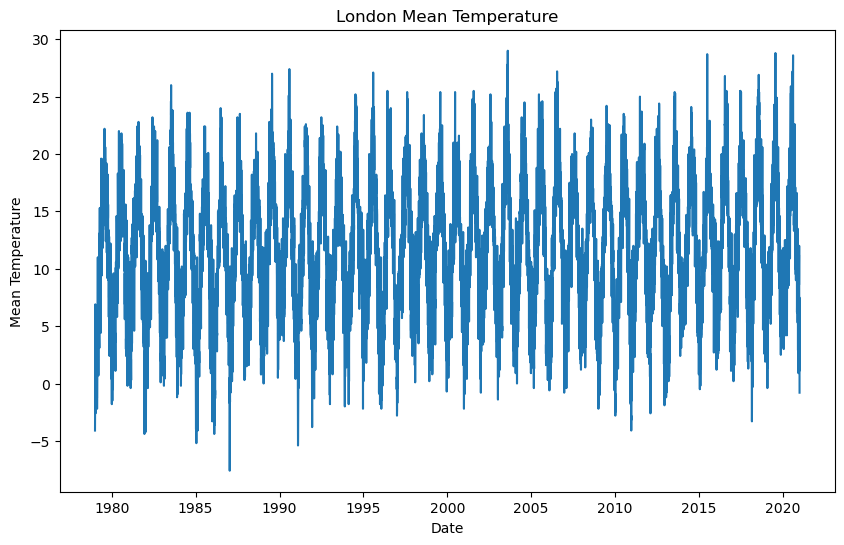

In [26]:
df["date"] = pd.to_datetime(df["date"], format = "%Y%m%d")

dates = df["date"] 
mean_temp = df["mean_temp"]

plt.figure(figsize = (10, 6))
plt.plot(dates, mean_temp)
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature")
plt.show()

### The Additive Model

There are different ways to model a time series, and we choose the additive model. We consider this because it works with negative values, is easy to interpret and easy to compute.

We model a time series as trend ($m_{t}$) + seasonality ($S_{t}$) + noise ($Y_{t}$):

$$X_{t} = m_{t} + S_{t} + Y_{t}, t = 1, ..., n.$$

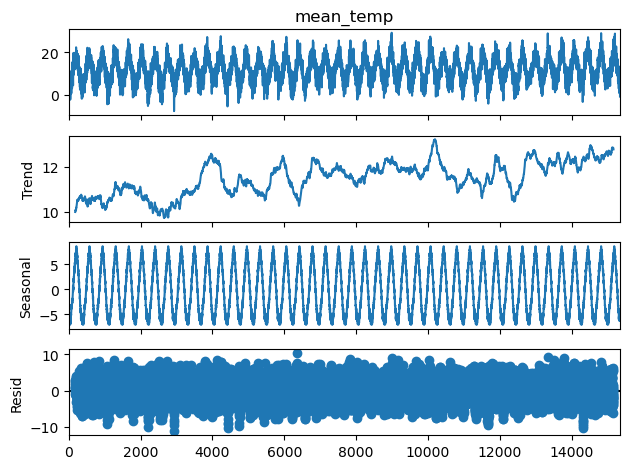

In [27]:
# Use 'statsmodels' library to decompose time series into trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
# Decompose time series data, over a period of 365 days (a year)
result = seasonal_decompose(mean_temp, model = "additive", period = 365)
result.plot()
plt.show()

### Transforming the Data

Typically in time series analysis, transformations are applied to data in order to stabilise the variance. Common methods include the Box-Cox transformation and the natural logarithm, but we are working with data that can be both negative and positive. We decide to perform simple standardisation on the data for this reason.

In [28]:
# Use 'StandardScaler()' to demean and scale to unit variance (standardise)
stand_scale = StandardScaler()
ts_data = stand_scale.fit_transform(np.array(mean_temp).reshape(-1, 1)).astype('float32')

ts_data

array([[-2.7191172],
       [-2.4572635],
       [-2.4921772],
       ...,
       [-1.5495043],
       [-1.5320474],
       [-2.1430392]], dtype=float32)

### Check if GPU Exists on Machine

In [29]:
# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print("Device:", device)

Device: cpu


### Splitting the Dataset and Preparing the Data

We are going to try and predict the whole of 2020, which has 366 days (it is a leap year). This will be our test set, with the previous years acting as the training set. The data needs to be converted to a format that PyTorch supports.

In [30]:
from torch.autograd import Variable

# Function from 'https://colab.research.google.com/github/dlmacedo/starter-academic/blob/master/content/courses/deeplearning/notebooks/pytorch/Time_Series_Prediction_with_LSTM_Using_PyTorch.ipynb#scrollTo=NabsV8O5BBd5'
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data) - seq_length):
        _x = data[i:(i + seq_length)]
        _y = data[i + seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x), np.array(y)

# Define number of days for training and test sets, and sequence length
n = df.shape[0]
t = n - 366
seq_length = 4

# Apply function to data
x, y = sliding_windows(ts_data, seq_length)

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:t])))
trainY = Variable(torch.Tensor(np.array(y[0:t])))

testX = Variable(torch.Tensor(np.array(x[t:])))
testY = Variable(torch.Tensor(np.array(y[t:])))

trainX.shape, trainY.shape, testX.shape, testY.shape

(torch.Size([14975, 4, 1]),
 torch.Size([14975, 1]),
 torch.Size([362, 4, 1]),
 torch.Size([362, 1]))

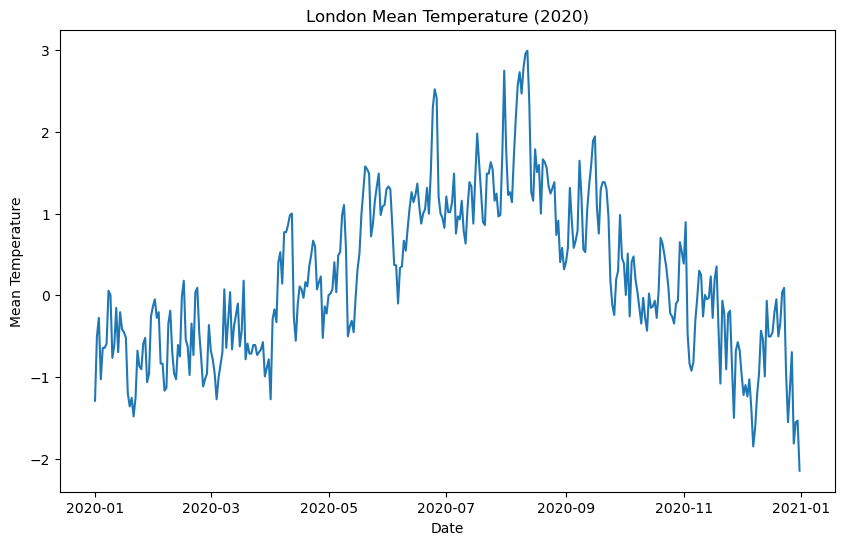

In [31]:
# Plot of 2020 data (standardised)
plt.figure(figsize = (10, 6))
plt.plot(dates[t:], ts_data[t:])
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature (2020)")
plt.show()

## LSTM

### Base Long Short-Term Memory (LSTM) Network Class

We create a Long Short-Term Memory Network class that takes 6 parameters, detailed below. We include an additional Dense layer and apply the Softmax activation function. Dropout can be enabled if desired.

In [32]:
import torch.nn as nn

class LSTM(nn.Module):
    """
    Long Short-Term Memory (LSTM) Network Class

    Parameters:
    - num_classes: The number of output classes.
    - input_size: The number of features in the input data.
    - hidden_size: The number of features in the hidden state of the LSTM.
    - num_layers: The number of stacked LSTM layers in the network.
    - dropout_rate: Introduces a Dropout layer on the outputs of each LSTM layer except the last layer. A float between 0 and 1, where 0 means no dropout.
    - random_state: Seed used to generate the random weights. If no seed is specified, the seed set as 'randomer' will be used.
    """
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate = 0, random_state = randomer):
        super(LSTM, self).__init__()

        # Store input parameters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        
        # Set random seed
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout_rate)
        
        # Define fully connected layers
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)
        
        # Define activation function (Softmax)
        self.softmax = nn.Softmax()
    
    def forward(self, x):
        # Initialise hidden state and cell state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # Reshape the hidden state
        hn = hn[-1].view(-1, self.hidden_size)  # Take the hidden state from the last layer

        # Apply Softmax activation function
        out = self.softmax(hn)

        # Apply the first fully connected layer
        out = self.fc_1(out)

        # Apply Softmax activation function
        out = self.softmax(out)

        # Apply the final fully connected layer
        out = self.fc(out)

        return out

### Set Hyperparameters

In [33]:
# Number of epochs, learning rate
num_epochs = 2000
learning_rate = 0.01

# Number of features, number of features in hidden state, number of stacked LSTM layers, number of output classes, dropout rate
input_size = 1
hidden_size = 2
num_layers = 1
num_classes = 1
dropout_rate = 0

### Train LSTM Network

We define our LSTM object, loss function and optimiser to be used in the model training. We then train the model on the training set for each epoch.

In [34]:
# Define LSTM object using above hyperparameters
lstm = LSTM(num_classes, input_size, hidden_size, num_layers, dropout_rate = dropout_rate, random_state = randomer)

# Use mean-squared error loss
criterion = torch.nn.MSELoss()

# Use root-mean-squared-propagation optimiser with set learning rate
optimiser = torch.optim.RMSprop(lstm.parameters(), lr = learning_rate)

In [35]:
# Create list to store losses
losses = []

# Train the model for every epoch
for epoch in range(num_epochs):
    # Forward pass using training data
    outputs = lstm(trainX)
    
    # Calculate the gradient and set it to zero
    optimiser.zero_grad()
    
    # Obtain the loss function
    loss = criterion(outputs, trainY)
    
    # Calculate the loss at current epoch
    loss.backward()
    
    # Append loss to 'losses' list
    losses.append(loss.item())
    
    # Use optimiser to improve model, by reducing the loss
    optimiser.step()
    
    # Output loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 1.003619909286499
Epoch: 100, Loss: 0.1373605579137802
Epoch: 200, Loss: 0.12222204357385635
Epoch: 300, Loss: 0.11844590306282043
Epoch: 400, Loss: 0.1167144849896431
Epoch: 500, Loss: 0.11569249629974365
Epoch: 600, Loss: 0.11507079005241394
Epoch: 700, Loss: 0.11465699970722198
Epoch: 800, Loss: 0.11436964571475983
Epoch: 900, Loss: 0.11413867771625519
Epoch: 1000, Loss: 0.11394301056861877
Epoch: 1100, Loss: 0.11378002166748047
Epoch: 1200, Loss: 0.1136346235871315
Epoch: 1300, Loss: 0.11350847035646439
Epoch: 1400, Loss: 0.11340029537677765
Epoch: 1500, Loss: 0.11330818384885788
Epoch: 1600, Loss: 0.11322923749685287
Epoch: 1700, Loss: 0.113161101937294
Epoch: 1800, Loss: 0.11310195177793503
Epoch: 1900, Loss: 0.11304965615272522


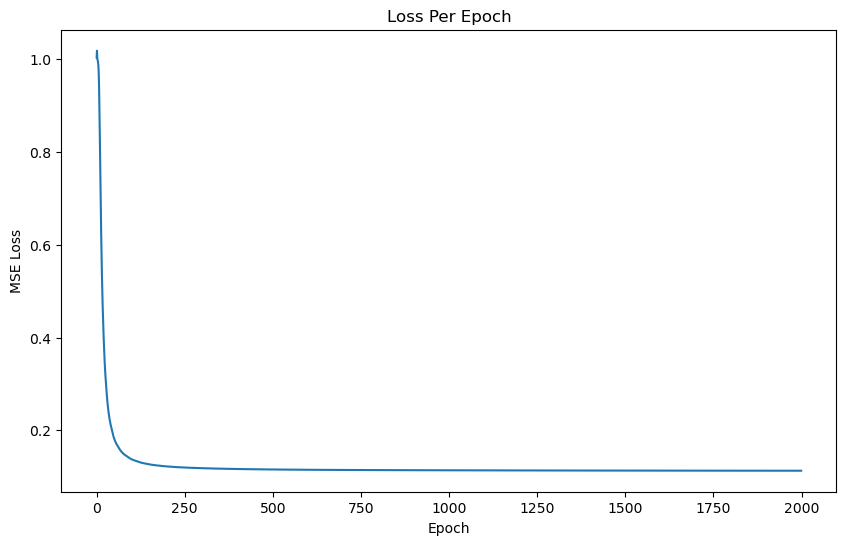

In [36]:
# Plot losses
plt.figure(figsize = (10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Per Epoch")
plt.savefig("losses_train.pdf")
plt.show()

### Make Predictions

Using our trained model, we test it on the year 2020. We make predictions of the daily mean temperatures during 2020, and compare this with the actual temperatures in a plot.

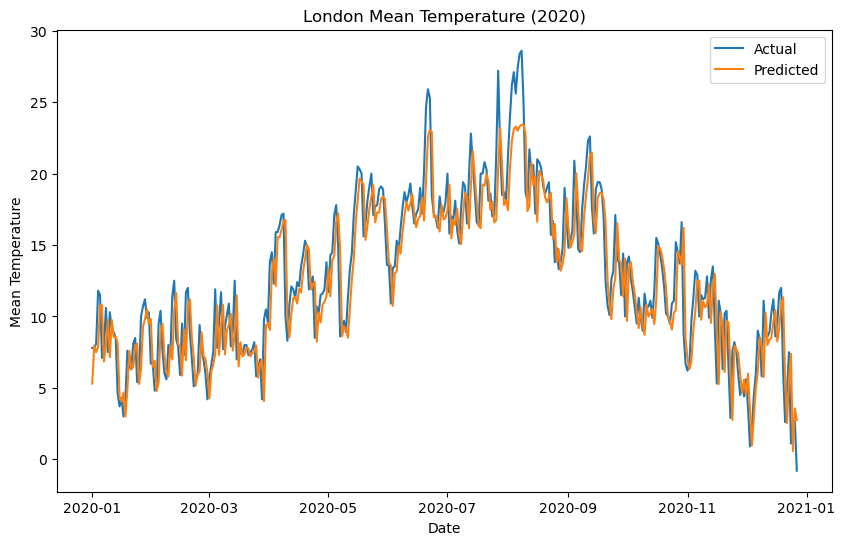

In [37]:
from datetime import datetime, timedelta

# Get predictions from LSTM network, by performing a forward pass using test data
predictions = lstm(testX)

# Convert predictions and actual data to NumPy arrays
predictions_numpy = predictions.data.numpy()
actual_numpy = testY.data.numpy()

# Reverse transformation from 'StandardScaler()'
predictions_numpy = stand_scale.inverse_transform(predictions_numpy)
actual_numpy = stand_scale.inverse_transform(actual_numpy)

# Generate dates during January 2020
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 27)
date_range = [start_date + timedelta(days = x) for x in range((end_date - start_date).days + 1)]

# Plot actual and predicted data
plt.figure(figsize = (10, 6))
plt.plot(date_range, actual_numpy, label = "Actual")
plt.plot(date_range, predictions_numpy, label = "Predicted")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature (2020)")
plt.legend()
plt.savefig("london_mean_temp_fit.pdf")
plt.show()

### Improving the Model

We use the ReLU activation function instead of the Softmax activation function and use the Adam optimiser. The hyperparameters remain the same as before.

In [38]:
class LSTM_new(nn.Module):
    """
    Long Short-Term Memory (LSTM) Network Class

    Parameters:
    - num_classes: The number of output classes.
    - input_size: The number of features in the input data.
    - hidden_size: The number of features in the hidden state of the LSTM.
    - num_layers: The number of stacked LSTM layers in the network.
    - dropout_rate: Introduces a Dropout layer on the outputs of each LSTM layer except the last layer. A float between 0 and 1, where 0 means no dropout.
    - random_state: Seed used to generate the random weights. If no seed is specified, the seed set as 'randomer' will be used.
    """
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_rate = 0, random_state = randomer):
        super(LSTM_new, self).__init__()

        # Store input parameters
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout_rate = dropout_rate
        self.random_state = random_state
        
        # Set random seed
        torch.manual_seed(random_state)
        np.random.seed(random_state)
        
        # Define the LSTM layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, dropout = dropout_rate)
        
        # Define fully connected layers
        self.fc_1 = nn.Linear(hidden_size, 128) 
        self.fc = nn.Linear(128, num_classes) 
        
        # Define activation function (ReLU)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        # Initialise hidden state and cell state
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0))

        # Reshape the hidden state
        hn = hn[-1].view(-1, self.hidden_size)  # Take the hidden state from the last layer

        # Apply ReLU activation function
        out = self.relu(hn)

        # Apply the first fully connected layer
        out = self.fc_1(out)

        # Apply ReLU activation function
        out = self.relu(out)
        
        # Apply the final fully connected layer
        out = self.fc(out)

        return out

In [39]:
# Define LSTM object using previous hyperparameters
lstm_new = LSTM_new(num_classes, input_size, hidden_size, num_layers, dropout_rate = dropout_rate, random_state = randomer)

# Use mean-squared error loss
criterion_new = torch.nn.MSELoss()

# Use Adam optimiser with set learning rate
optimiser_new = torch.optim.Adam(lstm_new.parameters(), lr = learning_rate)

In [40]:
# Create list to store losses
losses = []

# Train the model for every epoch
for epoch in range(num_epochs):
    # Forward pass using training data
    outputs = lstm_new(trainX)
    
    # Calculate the gradient and set it to zero
    optimiser_new.zero_grad()
    
    # Obtain the loss function
    loss = criterion_new(outputs, trainY)
    
    # Calculate the loss at current epoch
    loss.backward()
    
    # Append loss to 'losses' list
    losses.append(loss.item())
    
    # Use optimiser to improve model, by reducing the loss
    optimiser_new.step()
    
    # Output loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 1.0544646978378296


Epoch: 100, Loss: 0.11143098026514053
Epoch: 200, Loss: 0.10960972309112549
Epoch: 300, Loss: 0.10944068431854248
Epoch: 400, Loss: 0.10924924165010452
Epoch: 500, Loss: 0.1091642677783966
Epoch: 600, Loss: 0.10906492173671722
Epoch: 700, Loss: 0.10895659774541855
Epoch: 800, Loss: 0.10887635499238968
Epoch: 900, Loss: 0.1087987944483757
Epoch: 1000, Loss: 0.1087564006447792
Epoch: 1100, Loss: 0.10870503634214401
Epoch: 1200, Loss: 0.10861261934041977
Epoch: 1300, Loss: 0.10856269299983978
Epoch: 1400, Loss: 0.10852645337581635
Epoch: 1500, Loss: 0.10848971456289291
Epoch: 1600, Loss: 0.10846881568431854
Epoch: 1700, Loss: 0.10855716466903687
Epoch: 1800, Loss: 0.10840604454278946
Epoch: 1900, Loss: 0.10838481783866882


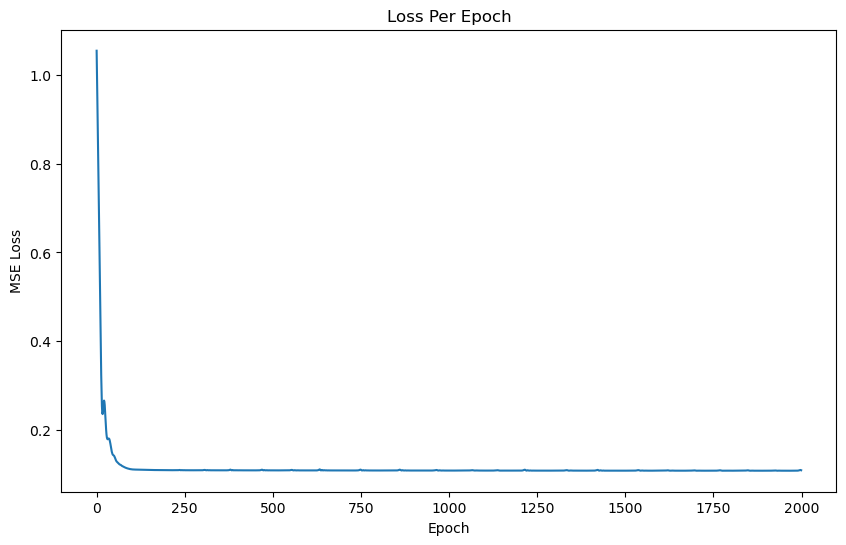

In [41]:
# Plot losses
plt.figure(figsize = (10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Per Epoch")
plt.savefig("losses_train_new.pdf")
plt.show()

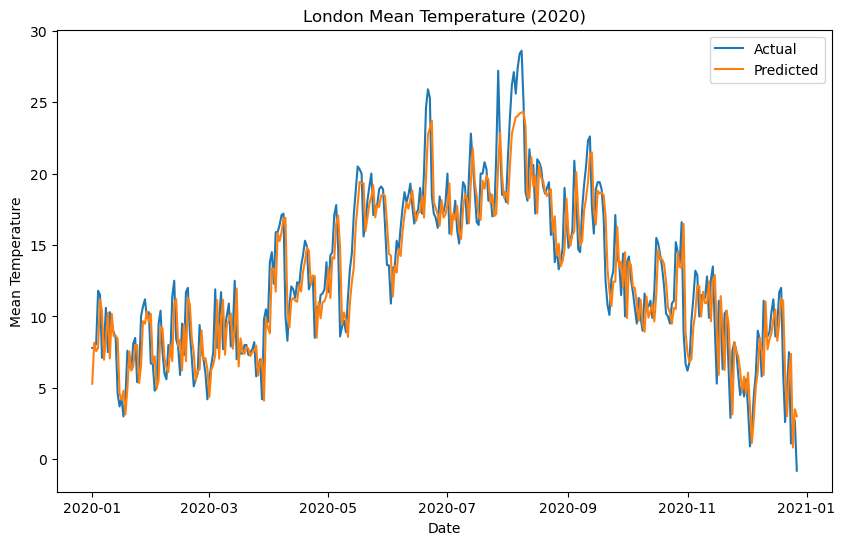

In [42]:
# Get predictions from LSTM network, by performing a forward pass using test data
predictions = lstm_new(testX)

# Convert predictions and actual data to NumPy arrays
predictions_numpy = predictions.data.numpy()
actual_numpy = testY.data.numpy()

# Reverse transformation from 'StandardScaler()'
predictions_numpy = stand_scale.inverse_transform(predictions_numpy)
actual_numpy = stand_scale.inverse_transform(actual_numpy)

# Generate dates during January 2020
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 27)
date_range = [start_date + timedelta(days = x) for x in range((end_date - start_date).days + 1)]

# Plot actual and predicted data
plt.figure(figsize = (10, 6))
plt.plot(date_range, actual_numpy, label = "Actual")
plt.plot(date_range, predictions_numpy, label = "Predicted")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature (2020)")
plt.legend()
plt.savefig("london_mean_temp_fit_new.pdf")
plt.show()

### Optimise Hyperparameters

We optimise the hyperparameters next, using our improved model. The number of epochs and stacked layers remains the same. Here we introduce dropout regularisation with proportion of 30%. The number of features in the hidden state is now 4.

In [43]:
# Number of epochs, learning rate
num_epochs = 2000
learning_rate = 0.01

# Number of features, number of features in hidden state, number of stacked LSTM layers, number of output classes, dropout rate
input_size = 1
hidden_size = 4
num_layers = 1
num_classes = 1
dropout_rate = 0

In [44]:
# Define LSTM object using above hyperparameters
lstm_hyper = LSTM_new(num_classes, input_size, hidden_size, num_layers, dropout_rate = dropout_rate, random_state = randomer)

# Use mean-squared error loss
criterion_hyper = torch.nn.MSELoss()

# Use Adam optimiser with set learning rate
optimiser_hyper = torch.optim.Adam(lstm_hyper.parameters(), lr = learning_rate)

In [45]:
# Create list to store losses
losses = []

# Train the model for every epoch
for epoch in range(num_epochs):
    # Forward pass using training data
    outputs = lstm_hyper(trainX)
    
    # Calculate the gradient and set it to zero
    optimiser_hyper.zero_grad()
    
    # Obtain the loss function
    loss = criterion_hyper(outputs, trainY)
    
    # Calculate the loss at current epoch
    loss.backward()
    
    # Append loss to 'losses' list
    losses.append(loss.item())
    
    # Use optimiser to improve model, by reducing the loss
    optimiser_hyper.step()
    
    # Output loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 1.0081697702407837


Epoch: 100, Loss: 0.11181461811065674
Epoch: 200, Loss: 0.1096571758389473
Epoch: 300, Loss: 0.10924822837114334
Epoch: 400, Loss: 0.10962311178445816
Epoch: 500, Loss: 0.11015966534614563
Epoch: 600, Loss: 0.1086563915014267
Epoch: 700, Loss: 0.1085425391793251
Epoch: 800, Loss: 0.10861733555793762
Epoch: 900, Loss: 0.10839227586984634
Epoch: 1000, Loss: 0.10834036767482758
Epoch: 1100, Loss: 0.11040905863046646
Epoch: 1200, Loss: 0.1082596480846405
Epoch: 1300, Loss: 0.10824650526046753
Epoch: 1400, Loss: 0.10820254683494568
Epoch: 1500, Loss: 0.10817735642194748
Epoch: 1600, Loss: 0.10817156732082367
Epoch: 1700, Loss: 0.10814218968153
Epoch: 1800, Loss: 0.10814370214939117
Epoch: 1900, Loss: 0.10811781883239746


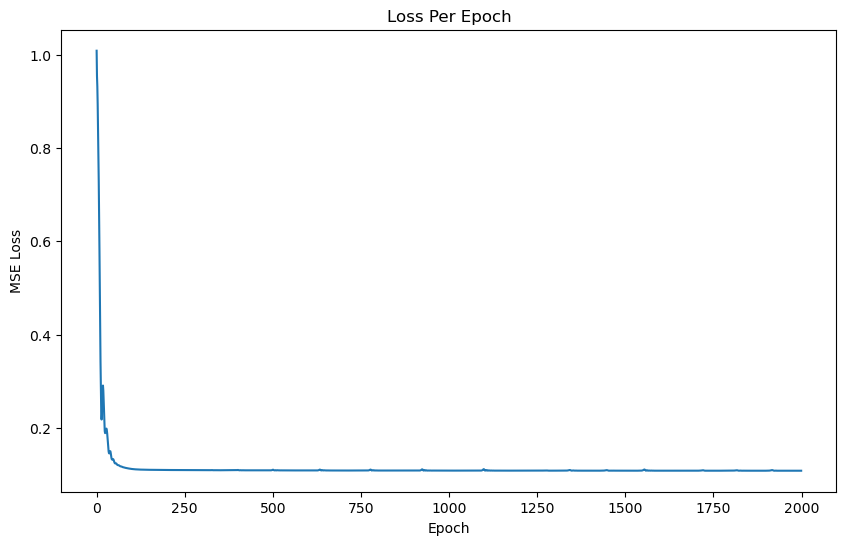

In [46]:
# Plot losses
plt.figure(figsize = (10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Per Epoch")
plt.savefig("losses_train_hyper.pdf")
plt.show()

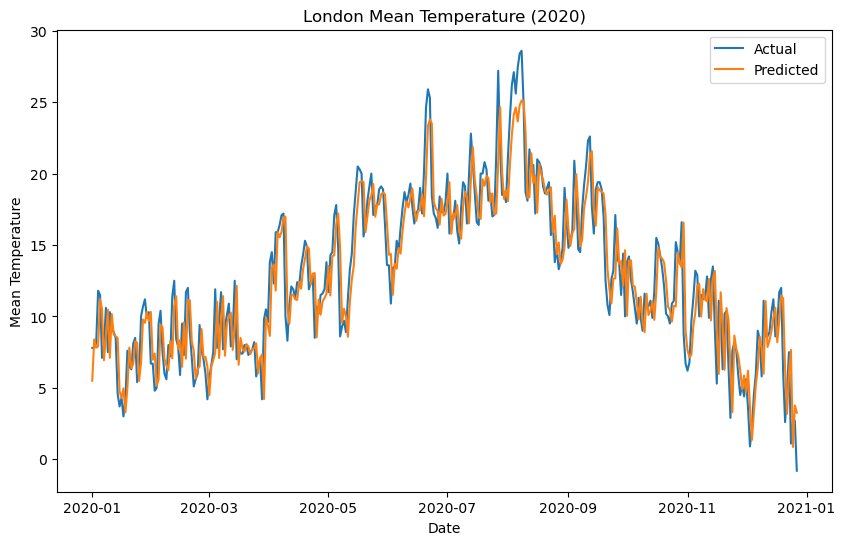

In [47]:
# Get predictions from LSTM network, by performing a forward pass using test data
predictions = lstm_hyper(testX)

# Convert predictions and actual data to NumPy arrays
predictions_numpy = predictions.data.numpy()
actual_numpy = testY.data.numpy()

# Reverse transformation from 'StandardScaler()'
predictions_numpy = stand_scale.inverse_transform(predictions_numpy)
actual_numpy = stand_scale.inverse_transform(actual_numpy)

# Generate dates during January 2020
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 27)
date_range = [start_date + timedelta(days = x) for x in range((end_date - start_date).days + 1)]

# Plot actual and predicted data
plt.figure(figsize = (10, 6))
plt.plot(date_range, actual_numpy, label = "Actual")
plt.plot(date_range, predictions_numpy, label = "Predicted")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature (2020)")
plt.legend()
plt.savefig("london_mean_temp_fit_hyper.pdf")
plt.show()

### Alternate Hyperparameter Optimisation

We optimise the hyperparameters again using our improved model, this time including dropout regularisation. The number of stacked LSTM layers is now 2 to allow for dropout, at 30%.

In [48]:
# Number of epochs, learning rate
num_epochs = 2000
learning_rate = 0.01

# Number of features, number of features in hidden state, number of stacked LSTM layers, number of output classes, dropout rate
input_size = 1
hidden_size = 4
num_layers = 2
num_classes = 1
dropout_rate = 0.3

In [49]:
# Define LSTM object using above hyperparameters
lstm_hyper2 = LSTM_new(num_classes, input_size, hidden_size, num_layers, dropout_rate = dropout_rate, random_state = randomer)

# Use mean-squared error loss
criterion_hyper2 = torch.nn.MSELoss()

# Use Adam optimiser with set learning rate
optimiser_hyper2 = torch.optim.Adam(lstm_hyper2.parameters(), lr = learning_rate)

In [50]:
# Create list to store losses
losses = []

# Train the model for every epoch
for epoch in range(num_epochs):
    # Forward pass using training data
    outputs = lstm_hyper2(trainX)
    
    # Calculate the gradient and set it to zero
    optimiser_hyper2.zero_grad()
    
    # Obtain the loss function
    loss = criterion_hyper2(outputs, trainY)
    
    # Calculate the loss at current epoch
    loss.backward()
    
    # Append loss to 'losses' list
    losses.append(loss.item())
    
    # Use optimiser to improve model, by reducing the loss
    optimiser_hyper2.step()
    
    # Output loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch: {epoch}, Loss: {loss.item()}")

Epoch: 0, Loss: 1.0022226572036743


Epoch: 100, Loss: 0.1555042862892151
Epoch: 200, Loss: 0.14303386211395264
Epoch: 300, Loss: 0.1351591944694519
Epoch: 400, Loss: 0.12923644483089447
Epoch: 500, Loss: 0.12456910312175751
Epoch: 600, Loss: 0.12317337095737457
Epoch: 700, Loss: 0.1227094903588295
Epoch: 800, Loss: 0.12155774980783463
Epoch: 900, Loss: 0.1211753711104393
Epoch: 1000, Loss: 0.12111617624759674
Epoch: 1100, Loss: 0.12061905860900879
Epoch: 1200, Loss: 0.119449682533741
Epoch: 1300, Loss: 0.11883567273616791
Epoch: 1400, Loss: 0.1180964931845665
Epoch: 1500, Loss: 0.11802128702402115
Epoch: 1600, Loss: 0.11643197387456894
Epoch: 1700, Loss: 0.11537723988294601
Epoch: 1800, Loss: 0.11515144258737564
Epoch: 1900, Loss: 0.11550154536962509


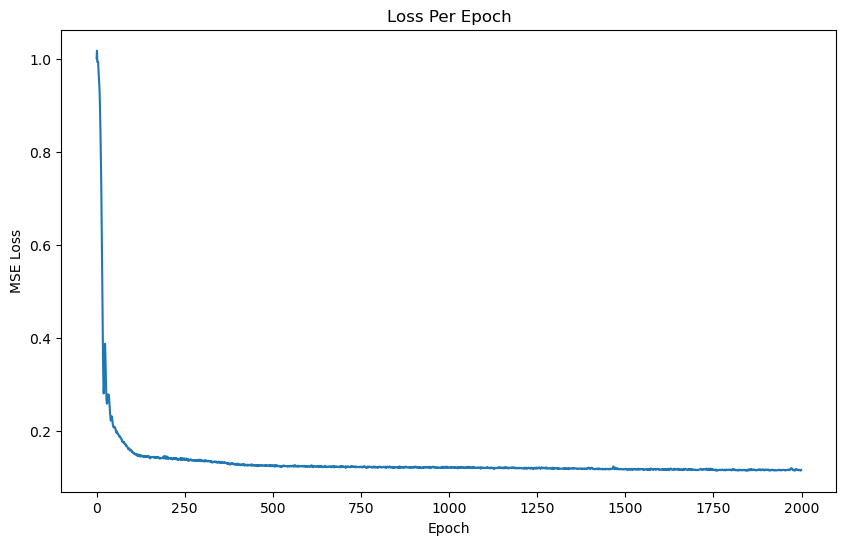

In [51]:
# Plot losses
plt.figure(figsize = (10, 6))
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Loss Per Epoch")
plt.savefig("losses_train_hyper2.pdf")
plt.show()

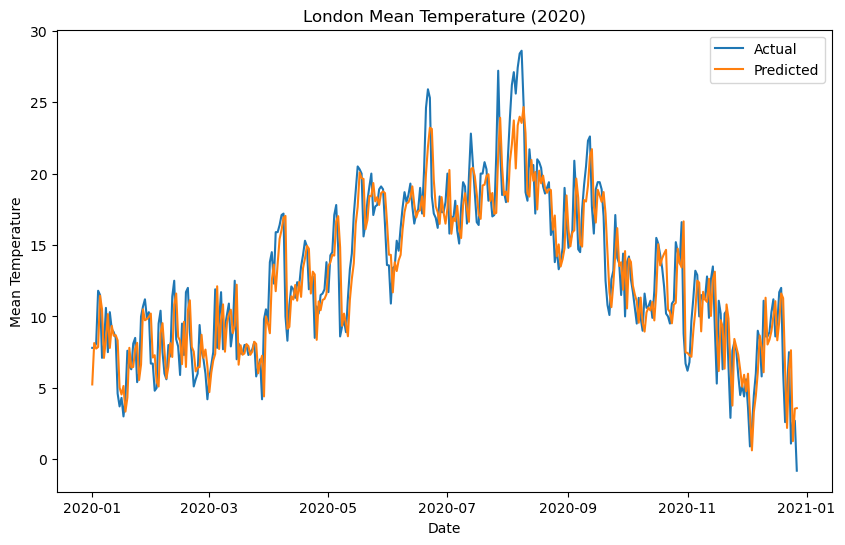

In [52]:
# Get predictions from LSTM network, by performing a forward pass using test data
predictions = lstm_hyper2(testX)

# Convert predictions and actual data to NumPy arrays
predictions_numpy = predictions.data.numpy()
actual_numpy = testY.data.numpy()

# Reverse transformation from 'StandardScaler()'
predictions_numpy = stand_scale.inverse_transform(predictions_numpy)
actual_numpy = stand_scale.inverse_transform(actual_numpy)

# Generate dates during January 2020
start_date = datetime(2020, 1, 1)
end_date = datetime(2020, 12, 27)
date_range = [start_date + timedelta(days = x) for x in range((end_date - start_date).days + 1)]

# Plot actual and predicted data
plt.figure(figsize = (10, 6))
plt.plot(date_range, actual_numpy, label = "Actual")
plt.plot(date_range, predictions_numpy, label = "Predicted")
plt.xlabel("Date")
plt.ylabel("Mean Temperature")
plt.title("London Mean Temperature (2020)")
plt.legend()
plt.savefig("london_mean_temp_fit_hyper2.pdf")
plt.show()